# TCSI Potential Cost Demonstration: Notebook
Author: John Hogland 4/20/2022

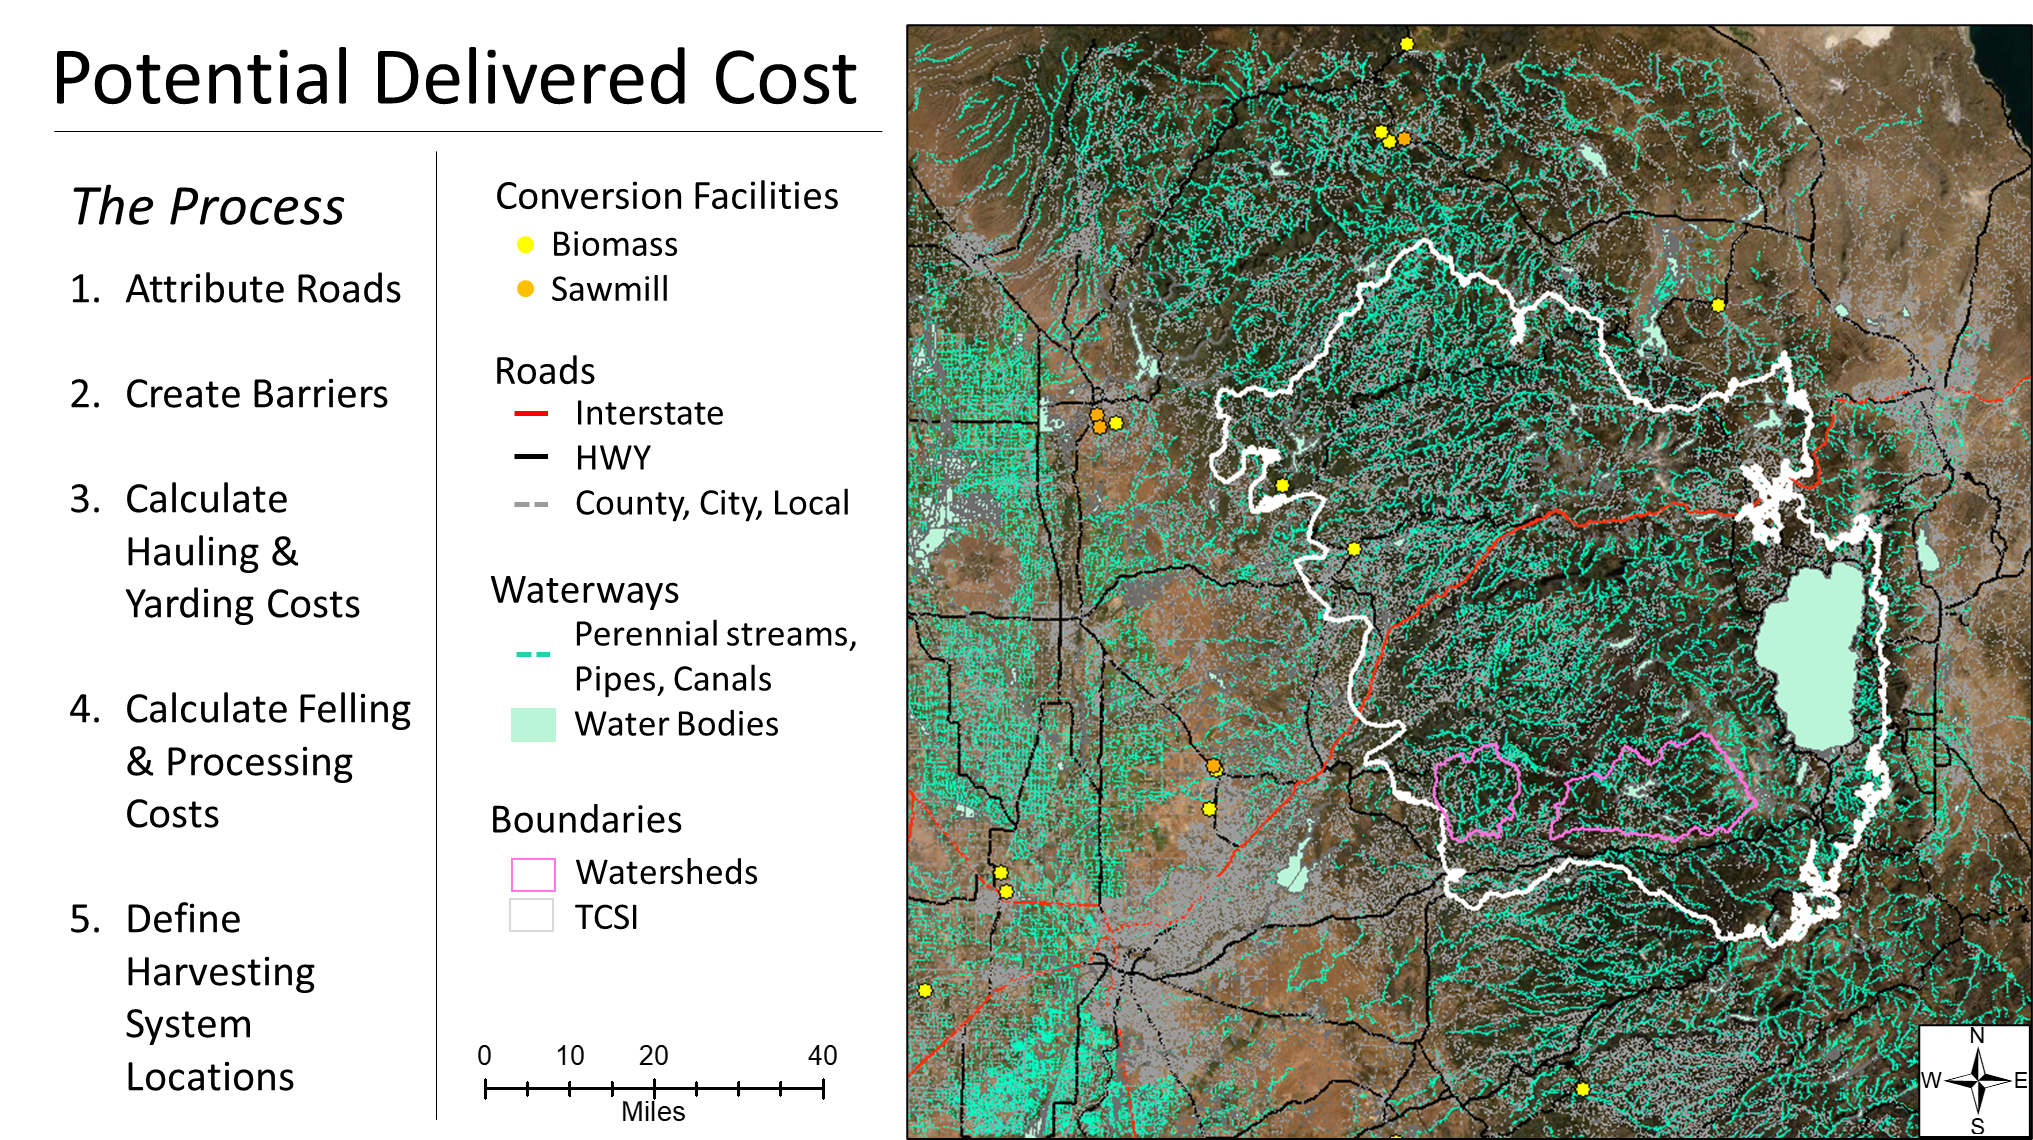

## Estimate Potential Costs for TCSI using raster_tools

In this notebook we will explore how we can estimate potential treatment costs in the TCSI study area.

note book requirements: 
- raster_tools - https://pypi.org/project/raster-tools/

## Install and update packages

In [1]:
# !pip install --upgrade gdown
# !pip install --upgrade numba
# !pip install --upgrade geopandas
# !pip install mapclassify
# !pip install --upgrade datascience
# !pip install --upgrade gym
# !pip install raster_tools

## Download the data
You can skip this step if you already have access to the data.

In [2]:

# import gdown, zipfile

# url = r'https://drive.google.com/file/d/1HKSfolOmKzyd6BjR3DLtu96ENc9I6MHM/view?usp=sharing'
# outfl= r'.\ACCEL_Notebook_data.zip'
# gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

# with zipfile.ZipFile(outfl, 'r') as zip_ref:
#    zip_ref.extractall(".")

## The Data (Accel.gdb)
This database consists of Raster and Vector datasets that we will be using throughout the example:
- elevation (raster): elevation surface units meters
- Forest_Mask (raster): binary surface used to identify forested areas (cell value = 1)
- roads (vector): tiger roads
- streams (vector): NHD streams
- water bodies (vector): NHD water bodies
- sawmills (vector): location of the sawmill
- biomass facilities (vector): location of biomass facilities


## Base Raster and Vector Datasets 
Import raster_tools and modules, specify paths, and make vector and raster objects.

In [13]:
#import raster_tools and modules 
from raster_tools import Raster, surface, distance, open_vectors, general, zonal, creation, Vector
import raster_tools
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

#specify paths to data layers
flgeodb = './Accel.gdb'
lyr_streams_path = 'NHDFlowLine'
lyr_roads_path = 'TigerRoads'
lyr_sawmill_path = 'Sawmills'
lyr_biomass_path = 'BiomassFacilities'
lyr_waterbody_path = 'NHDWaterBodies'
rs_elv_path = './Elevation.tif'
rs_fm_path = './Forest_Mask3.tif'

#get the vectors and rasters objects
strms, rds, saw, bio, wtrbd = open_vectors(flgeodb,[lyr_streams_path,lyr_roads_path,lyr_sawmill_path,lyr_biomass_path,lyr_waterbody_path])

#get rasters
elv=Raster(rs_elv_path).astype('int32')
frst=Raster(rs_fm_path).astype('int32')

## Subset TigerRoads & NHD
1. For TigerRoads we only want public roads (MTFCC: S1100,S1200,S1400,S1500,S1630)
2. For NHDFlowLine we only want perennial and piplines (FCode: not (55800, 56600, 33400, 46000, 46003, 46007, 42000, 42001, 42002, 42003)

In [5]:
strms_sub=Vector(strms.data[(strms.data['fcode'] != 55800) & (strms.data['fcode'] != 56600) & (strms.data['fcode'] != 33400) 
                     & (strms.data['fcode'] != 46000) & (strms.data['fcode'] != 46003) & (strms.data['fcode'] != 46007)
                     & (strms.data['fcode'] != 42000) & (strms.data['fcode'] != 42001) & (strms.data['fcode'] != 42002)
                     & (strms.data['fcode'] != 42003)])

rds_sub=Vector(rds.data[(rds.data['MTFCC'] == 'S1100') | (rds.data['MTFCC'] == 'S1200') | (rds.data['MTFCC'] == 'S1400')
                        | (rds.data['MTFCC'] == 'S1500') | (rds.data['MTFCC'] == 'S1630')])

## Plot the data

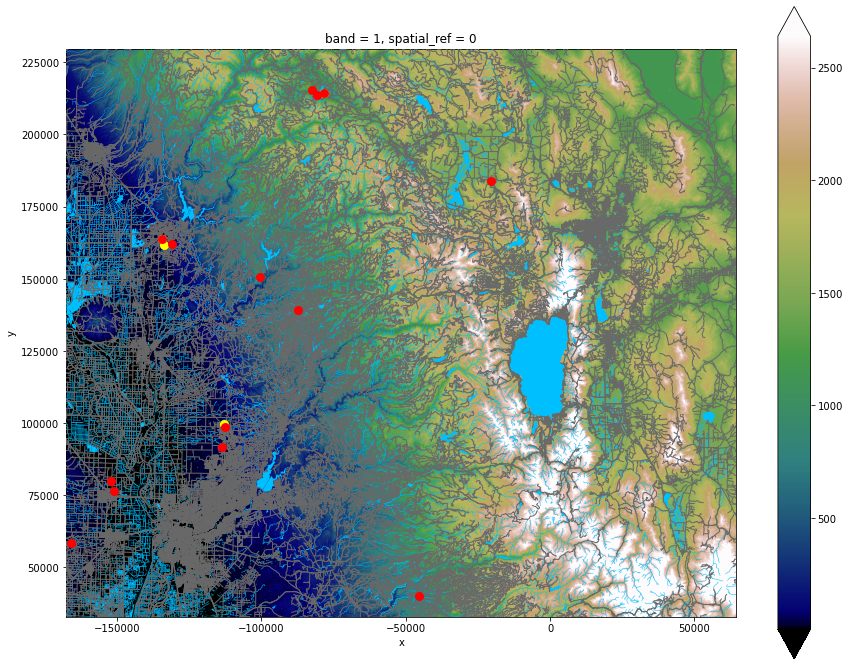

In [6]:
# plot the data
p0=bio.data.compute().plot(color='red',figsize=(15,12),zorder=6,linewidth=3)
p1=saw.data.compute().plot(ax=p0,color='yellow',zorder=5,linewidth=3)
p2=rds_sub.data.compute().plot(ax=p1,color='dimgray',zorder=4,linewidth=1)
p3=strms_sub.data.compute().plot(ax=p2,color='deepskyblue',zorder=3,linewidth=0.5)
p4=wtrbd.data.compute().plot(ax=p3,color='deepskyblue',zorder=2)
p5=elv.pxrs.plot(ax=p4,robust=True,cmap=plt.cm.gist_earth,zorder=1)
p5

# The Process
1. Attribute TigerRoads subset with speed based on criteria in **Table 1**.
2. Create barrier to offroad motion for off road analysis.
3. Estimate potential on road and offroad cost surfaces for each harvesting system using criteria in **Table 2**.
4. Create felling and processing surfaces and add potential costs.
5. Specify where harvesting systems occur and subset system costs to those locations.

**Table 1**. Road segment travel speed by tiger MTFCC class types.

|Query|Speed (KPH)|
|:-|:-:|
|MTFCC = “S1400”: Local Road, Rural Road, City Street|40|
MTFCC = “S1200”: Secondary road|56|
MTFCC = “S1100”: Primary road|88|
NOT (MTFCC = “S1400” OR MTFCC = “S1200” OR MTFCC = “S1100”)|40|

### 1. Attribute roads layer with speed values and conversion factors that can be used to estimate on road \$\CCF

In [7]:
#rds_sub=Vector(rds.data[(rds.data['RTTYP'] != 'M') & (rds.data['RTTYP'] != 'O')])
mtfcc_dic={'S1400':40,'S1200':56,'S1100':88}
rds_sub.data['kph']=rds_sub.data['MTFCC'].map(mtfcc_dic)
rds_sub.data['kph']=rds_sub.data['kph'].fillna(40)
rds_sub.data['conv']=2*((1/(rds_sub.data['kph']*1000))/12.5*98)

### 2. Create barriers to offroad motion

In [8]:
#Streams, cannals, and waterbodies
strms_rs_bar=strms_sub.to_raster(elv, all_touched=True).set_null_value(None) < 1 #convert the subset of streams into a raster and select all none stream cells
wtr_rs_bar=(wtrbd.to_raster(elv,all_touched=True).set_null_value(None)) < 1 # convert WaterBodies to a raster and select all none water body cells

# Interstates and Hwys
rds_sub2=Vector(rds_sub.data[(rds_sub.data['RTTYP'] == 'U') | (rds_sub.data['RTTYP'] == 'I')])
rds_rs_bar=rds_sub2.to_raster(elv).set_null_value(None) < 1 #convert interstate and state HWYs to a raster and select all none road cells

# Create barrier raster. Cell values of 1 mean equipment can move through the cell, valeus of zero mean equipment cannot move throught the cell.
bar = rds_rs_bar.eval()
bar2 = (bar*strms_rs_bar * wtr_rs_bar).eval()

### 3. Estimate distance surfaces

In [9]:
# create slope and road distance surfaces
slp = surface.slope(elv,degrees=False).eval() #compute so that slope only needs to be calculated once
c_rs = creation.constant_raster(elv).set_null_value(0) #constant value of 1 to multiply by distance
rds_rs = (rds_sub.to_raster(elv,'conv').set_null_value(0)).eval() #source surface with all non-road cells (value of zero) set to null
rd_dist=distance.cda_cost_distance(c_rs,(rds_rs>0).astype(int),elv)

# convert onroad rates and payload into on road cost surface that can be multiplied by the surface distance along a roadway to estimate hauling costs
saw_rs=(saw.to_raster(elv).set_null_value(0)).eval()
bio_rs=(bio.to_raster(elv).set_null_value(0)).eval()
on_d_saw = distance.cda_cost_distance(rds_rs,saw_rs,elv)
on_d_bio = distance.cda_cost_distance(rds_rs,bio_rs,elv)

In [10]:
# convert onroad surfaces to source surfaces measured in cents / CCF
src_saw = (on_d_saw * 100 * bar).astype(int)
src_bio = (on_d_bio * 100 * bar).astype(int)

In [11]:
# create offroad surface distance surfaces that can be muliplied by rates to estimate dollars per unit

#barriers to motion
b_dst_cs=bar.set_null_value(0) # helicopter
b_dst_cs2=bar2.set_null_value(0) # skidding and cable

#calc distance
saw_d,saw_t,saw_a=distance.cost_distance_analysis(b_dst_cs2,src_saw,elv)
saw_dh,saw_th,saw_ah=distance.cost_distance_analysis(b_dst_cs,src_saw,elv)

bio_d,bio_t,bio_a=distance.cost_distance_analysis(b_dst_cs2,src_bio,elv)
bio_dh,bio_th,bio_ah=distance.cost_distance_analysis(b_dst_cs,src_bio,elv)

### 4. Create harvesting system costs (hauling, yarding, felling, and processing; **Table 2**).

**Table 2**. Criteria used to spatially define harvesting systems and treatment costs. Machine rate of travel, and capacity estimates derived from meetings with Lisa Ball, Jacob Baker, Michael Jow, and Brian McCrory.

|Component|System|Rate|Rate of travel|Payload|Where it can occur|
|:-:|:-:|:-:|:-:|:-:|:-:|
|       |Rubber tire skidder|\$165/hr|2.44 KPH|1.25 CCF|Slopes <= 35% and Next to Roads ( distance < 460 m from a road).|
|Offroad|Skyline|\$400/hr|3.35KPH|1.04 CCF|Slopes > 35% and within 305 m of a road.|
|       |Helicopter|\$8,000/hr|3.85|1.67 CCF|Areas not covered by the other two and distance < 915 m from landing area.|
|Felling|Feller buncher|\$15/CCF|NA|NA|Slopes <= 35%|
|       |Hand Felling|\$27/CCF|NA|NA|Slopes > 35%|
|Processing|Delimbing, cutting to length, chipping, and loading|\$56/CCF|NA|NA|NA|
|On road|Log Truck|\$98/hour|Table 1|12.5 CCF|NA|
|Additional Treatments|Hand Treatment|\$2470/ha|NA|NA|Forested Areas|
|       |Prescribed fire|\$2470/ha|NA|NA|Forested Areas|

In [14]:
# Onroad, offroad, Felling, processing costs, and Additional Treatments
f1=slp<=0.35
fell=(f1*15).where(f1,27)
prc=creation.constant_raster(elv,56).astype(float)
oc=fell+prc

#Additional treatment costs (per/ha)
a_t=creation.constant_raster(elv,222.3).astype(float) #2470/ha*0.09ha
add_treat_cost=a_t*frst

# Convert offroad rates a mulitiply that can be used to calculate dollars per ccf given distance
s_c= (2 * (1/(2440))/1.25*165)
c_c= (2 * (1/(3350))/1.04*400)
h_c= (2 * (1/(3850))/1.67*8000)

# Calculate potential saw costs $/CCF
sk_saw_cost=(saw_d * s_c) + (saw_a/100) + oc
cb_saw_cost=(saw_d * c_c) + (saw_a/100) + oc
hd_saw_cost=(saw_dh * h_c) + (saw_ah/100) + oc

# Calculate potential bio costs $/CCF
sk_bio_cost = (bio_d * s_c) + (bio_a/100) + oc
cb_bio_cost = (bio_d * c_c) + (bio_a/100) + oc
hd_bio_cost = (bio_dh * h_c) + (bio_ah/100) + oc

#### Visualize harvesting systems potential costs (\$/CCF)
Rubber Tire Skidder, Cable, Helicopter for Sawlog and Biomass conversion facilities

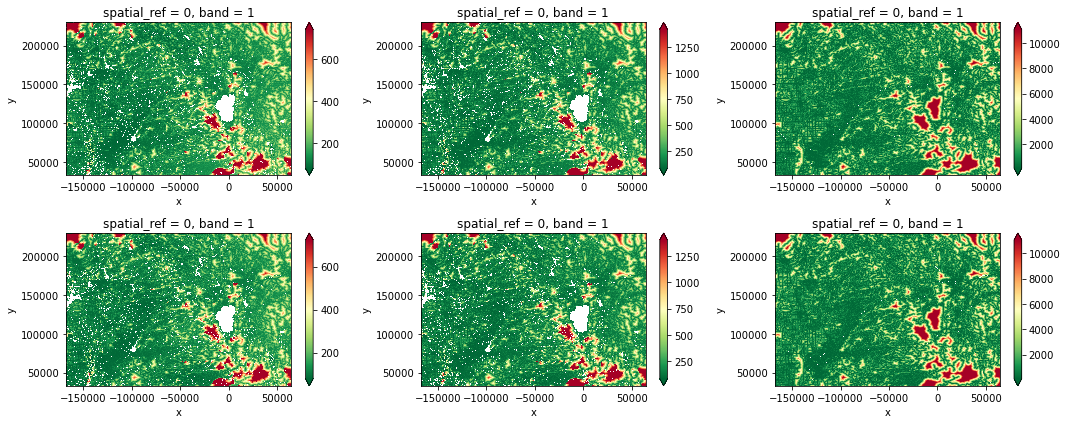

In [15]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(figsize=(15, 6), ncols=3, nrows=2,tight_layout=True)

cnt=0
rs_arr = [sk_saw_cost,cb_bio_cost,hd_saw_cost,sk_bio_cost,cb_saw_cost,hd_bio_cost] 
for x in rs_arr:
    rs_arr[cnt].pxrs.plot(ax=axes[cnt%2][cnt%3],cmap='RdYlGn_r',robust=True)
    cnt+=1

### 5. Specify where harvesting systems occur and subset harvesting system costs to those locations

In [16]:
# specify where each operation can occur
sb = ((slp<=0.35) & (rd_dist<460)) * frst
cb = ((slp>0.35) & (rd_dist<305)) * frst
hb = ((sb == 0) & (cb == 0) & (rd_dist < 915)) *frst

# Combine saw costs
skd_saw = sb * sk_saw_cost
cab_saw = cb * cb_saw_cost
hel_saw = hb * hd_saw_cost
saw_cost= (skd_saw + cab_saw + hel_saw).set_null_value(0).eval()

# Combine bio costs
skd_bio = sb * sk_bio_cost
cab_bio = cb * cb_bio_cost
hel_bio = hb * hd_bio_cost
bio_cost= (skd_bio + cab_bio + hel_bio).set_null_value(0).eval()

#### Save final outputs

In [17]:
saw_cost.save('saw_cost.tif')
bio_cost.save('bio_cost.tif')
add_treat_cost.save('additional_treatment_costs.tif')

<xarray.DataArray (band: 1, y: 6562, x: 7732)>
dask.array<open_rasterio-efb058b403b9d55de1e8c1229bd132ba<this-array>, shape=(1, 6562, 7732), dtype=float64, chunksize=(1, 3281, 3866), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -1.675e+05 -1.675e+05 ... 6.438e+04 6.441e+04
  * y            (y) float64 3.294e+04 3.297e+04 3.3e+04 ... 2.297e+05 2.298e+05
    spatial_ref  int32 0
Attributes:
    _FillValue:    -3.4028230607370965e+38
    scale_factor:  1.0
    add_offset:    0.0

#### Visualize combined potential costs $/CCF

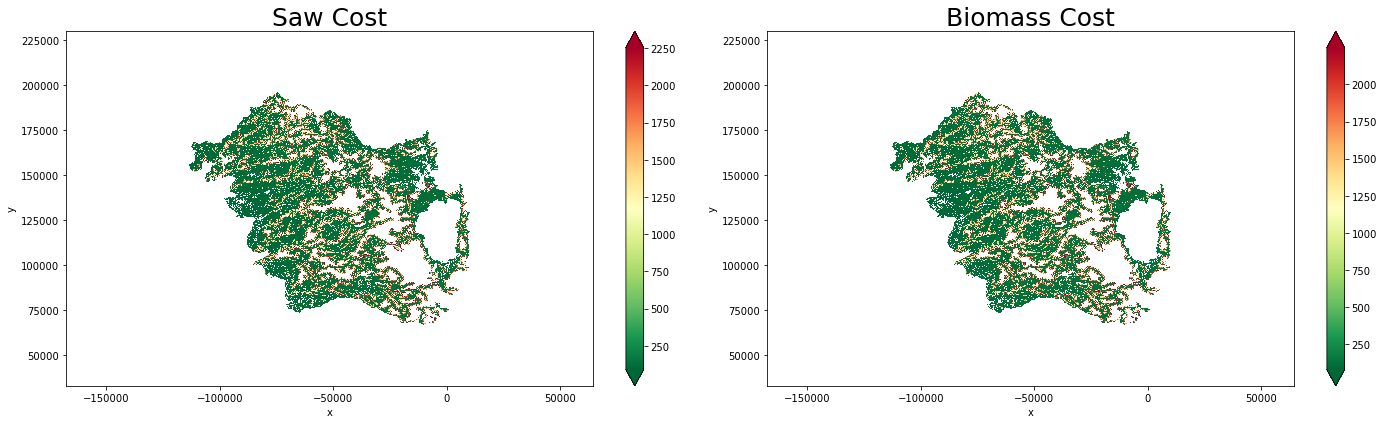

In [18]:
f, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1,tight_layout=True)

cnt=0
clms=['Saw Cost','Biomass Cost']
rs_arr = [saw_cost,bio_cost]
for x in clms:
    rs_arr[cnt].pxrs.plot(ax=axes[cnt],cmap='RdYlGn_r',robust=True)
    axes[cnt].set_title(x, fontdict={'fontsize': 25, 'fontweight' : 3})
    cnt+=1